# Graph composition

This notebook will explore the composition of the knowledge graph in terms of relation types, entity types, and fact sources.

In [1]:
import pandas as pd
import numpy as np

from utils.preprocessing import GraphParser

First we'll initialise an instance of the `GraphParser` class, which reads in the knowledge graph json file and parses it.

In [2]:
graph = GraphParser('data/KnowledgeGraph/SenescenceKG.json')

Now we can get the frequency of different types of relations from different sources. We'll explore relation types within four categories:

- Gene-term relationships from Gene Ontology (GO)
- Term-term relationships from Gene Ontology (GO)
- Gene-gene relationships from Pathway Commons
- Drug-gene relationships from DrugBank

In [3]:
# function for getting frequencies of different link types, filtering low-frequency types
def get_cat_freqs(link_types, threshold = 0.005, norm = True):
    freqs = link_types.value_counts(normalize = norm)
    low_count_types = freqs < threshold
    other_type_freq = sum(freqs[low_count_types])
    freqs = freqs.drop(freqs[low_count_types].index)
    if other_type_freq > 0:
        freqs['OTHER'] = other_type_freq    
    return freqs

GO_gene_rel_types = pd.Series([rel['label'] for rel in graph.relation_entries.values() 
                               if rel['properties']['source'] == 'Gene ontology' 
                               and ('Gene' in rel['end']['labels'] or 
                                    'Gene' in rel['start']['labels'])])
GO_gene_rel_type_freqs = get_cat_freqs(GO_gene_rel_types)

GO_term_rel_types = pd.Series([rel['label'] for rel in graph.relation_entries.values() 
                               if rel['properties']['source'] == 'Gene ontology' 
                               and ('GeneOntologyTerm' in rel['end']['labels'] and 
                                    'GeneOntologyTerm' in rel['start']['labels'])])
GO_term_rel_type_freqs = get_cat_freqs(GO_term_rel_types)

PC_gene_rel_types = pd.Series([rel['label'] for rel in graph.relation_entries.values() 
                               if 'Reactome' in rel['properties']['source']
                               or 'BioGRID' in rel['properties']['source']
                               or 'KEGG' in rel['properties']['source']])
PC_gene_rel_type_freqs = get_cat_freqs(PC_gene_rel_types)

DB_gene_rel_types = pd.Series([rel['label'] for rel in graph.relation_entries.values() 
                               if rel['properties']['source'] == 'Drugbank'])
DB_gene_rel_type_freqs = get_cat_freqs(DB_gene_rel_types)

Within each of these four categories, we can plot the frequencies of different relation labels.

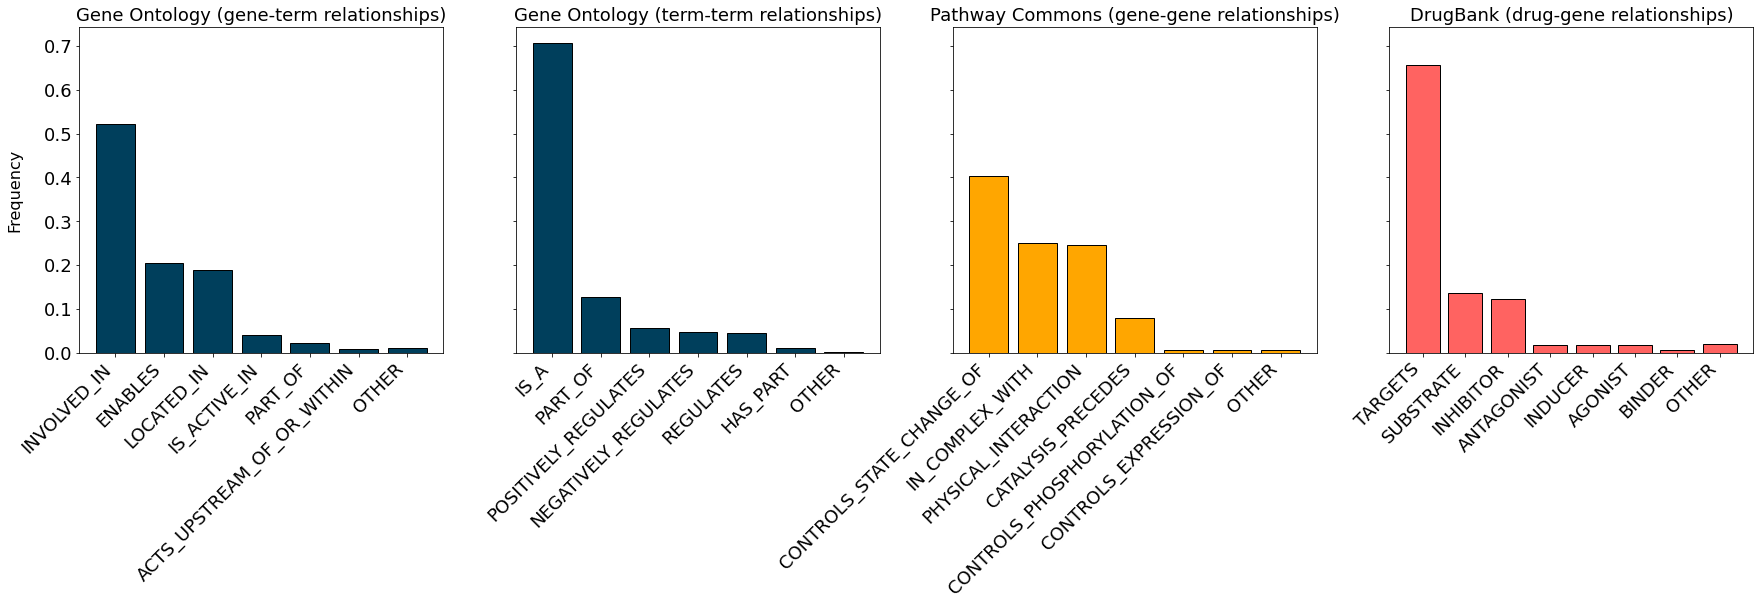

In [13]:
import matplotlib.pyplot as plt

colors = {'GO': '#003f5c', 'PC': '#ffa600', 'remap': '#bc5090', 'drugbank': '#ff6361', 'genes': '#58508d'}

fig, axs = plt.subplots(1, 4, sharey = True, figsize = (30, 6))
plt.rcParams['font.size'] = 18

axs[0].bar(x = GO_gene_rel_type_freqs.index, edgecolor = 'black', 
           height = GO_gene_rel_type_freqs.values, color = colors['GO'])
axs[0].set_ylabel('Frequency\n', fontsize = 16)
axs[1].bar(x = GO_term_rel_type_freqs.index, edgecolor = 'black', 
           height = GO_term_rel_type_freqs.values, color = colors['GO'])
axs[2].bar(x = PC_gene_rel_type_freqs.index, edgecolor = 'black',
           height = PC_gene_rel_type_freqs.values, color = colors['PC'])
axs[3].bar(x = DB_gene_rel_type_freqs.index, edgecolor = 'black', 
           height = DB_gene_rel_type_freqs.values, color = colors['drugbank'])

for ax, title in zip(axs, ['Gene Ontology (gene-term relationships)', 
                           'Gene Ontology (term-term relationships)',
                           'Pathway Commons (gene-gene relationships)', 
                           'DrugBank (drug-gene relationships)']):
    ax.set_title(title, fontsize = 18)
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right') 
    
plt.savefig('../figures/fig2a.png', facecolor = 'white', dpi = 300, bbox_inches = 'tight')

Now we'll examine the sources of facts in the knowledge graph. First we can extract the source of each fact from our instance of the `GraphParser` class.

In [5]:
# get all relationship sources
relation_sources = pd.Series([src for rel in graph.relation_entries.values() for src in rel['properties']['source'].split('; ')])
relation_source_freqs = get_cat_freqs(relation_sources, threshold = 0.001, norm = False)

Then we can plot the number of facts from each source.

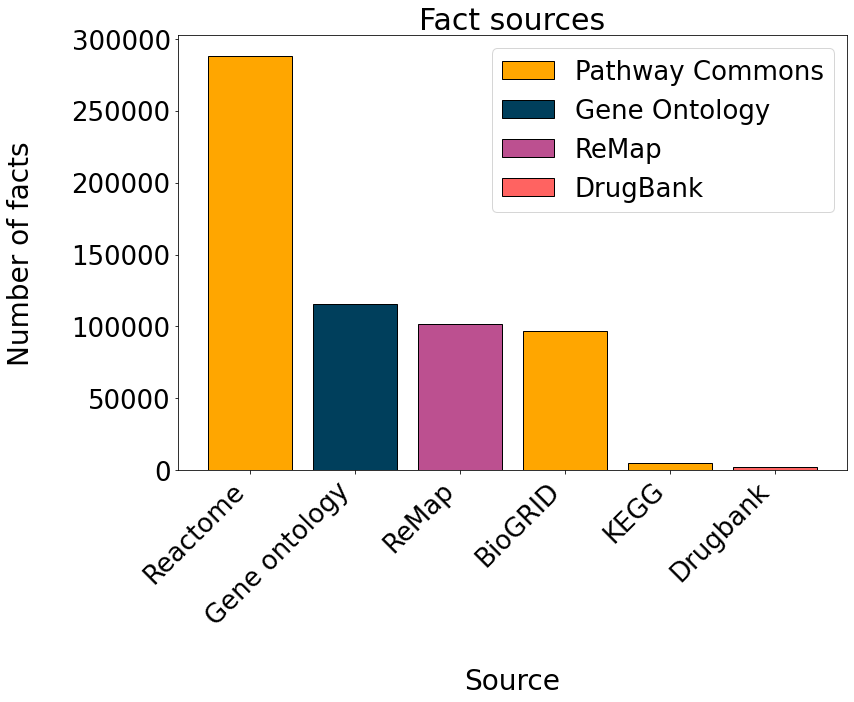

In [6]:
from matplotlib.patches import Patch

plt.rcParams['font.size'] = 26
fig = plt.figure(figsize = (12, 8))
bars = plt.bar(x = relation_source_freqs.index, 
               height = relation_source_freqs.values,
               edgecolor = 'black', 
               color = [colors['PC'], colors['GO'], colors['remap'], colors['PC'], colors['PC'], colors['drugbank']])
patches = [Patch(facecolor = colors[src], edgecolor = 'black') for src in ['PC', 'GO', 'remap', 'drugbank']]
plt.legend(handles = patches, labels = ['Pathway Commons', 'Gene Ontology', 'ReMap', 'DrugBank'])
plt.xlabel('\nSource', fontsize = 28)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Number of facts\n', fontsize = 28)
plt.title('Fact sources', fontsize = 30)
plt.savefig('../figures/fig2b.png', facecolor = 'white', dpi = 300, bbox_inches = 'tight')

Finally we'll plot the frequencies of different entity types in the graph.

In [7]:
# get all relationship sources
node_type_freqs = pd.Series(0, index = ['Drug', 'GO term', 'Gene'])
node_type_freqs['Drug'] = len([node for node in graph.node_entries.values() if 'Drug' in node['labels']])
node_type_freqs['GO term'] = len([node for node in graph.node_entries.values() if 'GeneOntologyTerm' in node['labels']])
node_type_freqs['Gene'] = len([node for node in graph.node_entries.values() if 'Gene' in node['labels']])

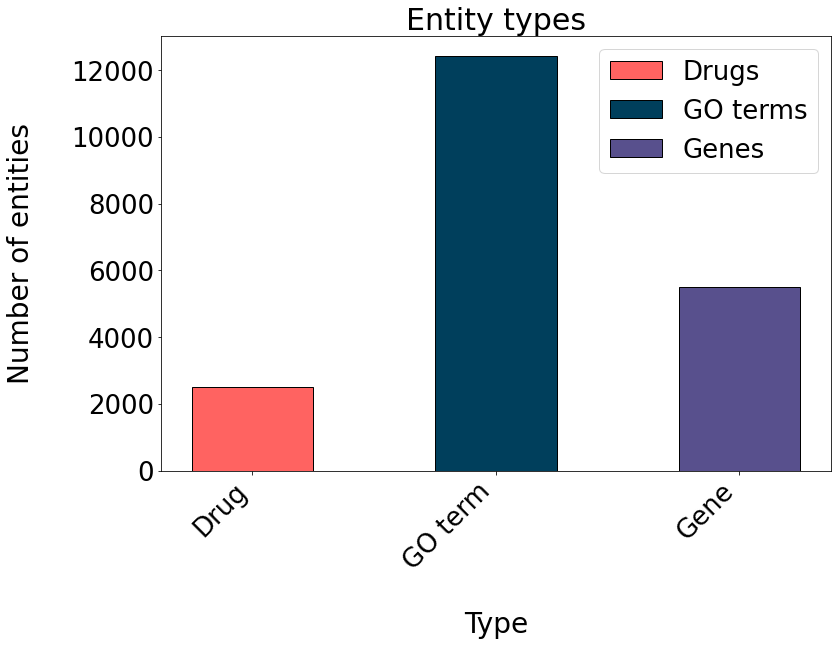

In [8]:
from matplotlib.patches import Patch

plt.rcParams['font.size'] = 26
fig = plt.figure(figsize = (12, 8))
bars = plt.bar(x = node_type_freqs.index, 
               height = node_type_freqs.values,
               edgecolor = 'black', 
               color = [colors['drugbank'], colors['GO'], colors['genes']],
               width = 0.5)
patches = [Patch(facecolor = colors[src], edgecolor = 'black') for src in ['drugbank', 'GO', 'genes']]
plt.legend(handles = patches, labels = ['Drugs', 'GO terms', 'Genes'])
plt.xlabel('\nType', fontsize = 28)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Number of entities\n', fontsize = 28)
plt.title('Entity types', fontsize = 30)
plt.savefig('../figures/fig2c.png', facecolor = 'white', dpi = 300, bbox_inches = 'tight')